# Task 2: Flowers classification
Dmytro Geleshko

## Imports

In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

## TF Config

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data
### Defining classes

In [4]:
classes = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

### Loading data

We can use tensorflow's fucntion to create image dataset from a directory, but for the sake of simplicity and ease of use with opencv, we will load it manually.

In [5]:
# array of labeled data: [x, y]
data = []

for i, c_name in enumerate(classes):
    count = 0
    path = "data/" + c_name
    for root, dir, files in os.walk(path):
        for file_name in files:
            if file_name.endswith(".jpg"):
                data.append([cv2.imread(path + "/" + file_name), i])
                count += 1
    print("Loaded", count, "images of", classes[i])

Loaded 518 images of daisy
Loaded 239 images of dandelion
Loaded 472 images of roses
Loaded 420 images of sunflowers
Loaded 602 images of tulips


### Preview examples of data

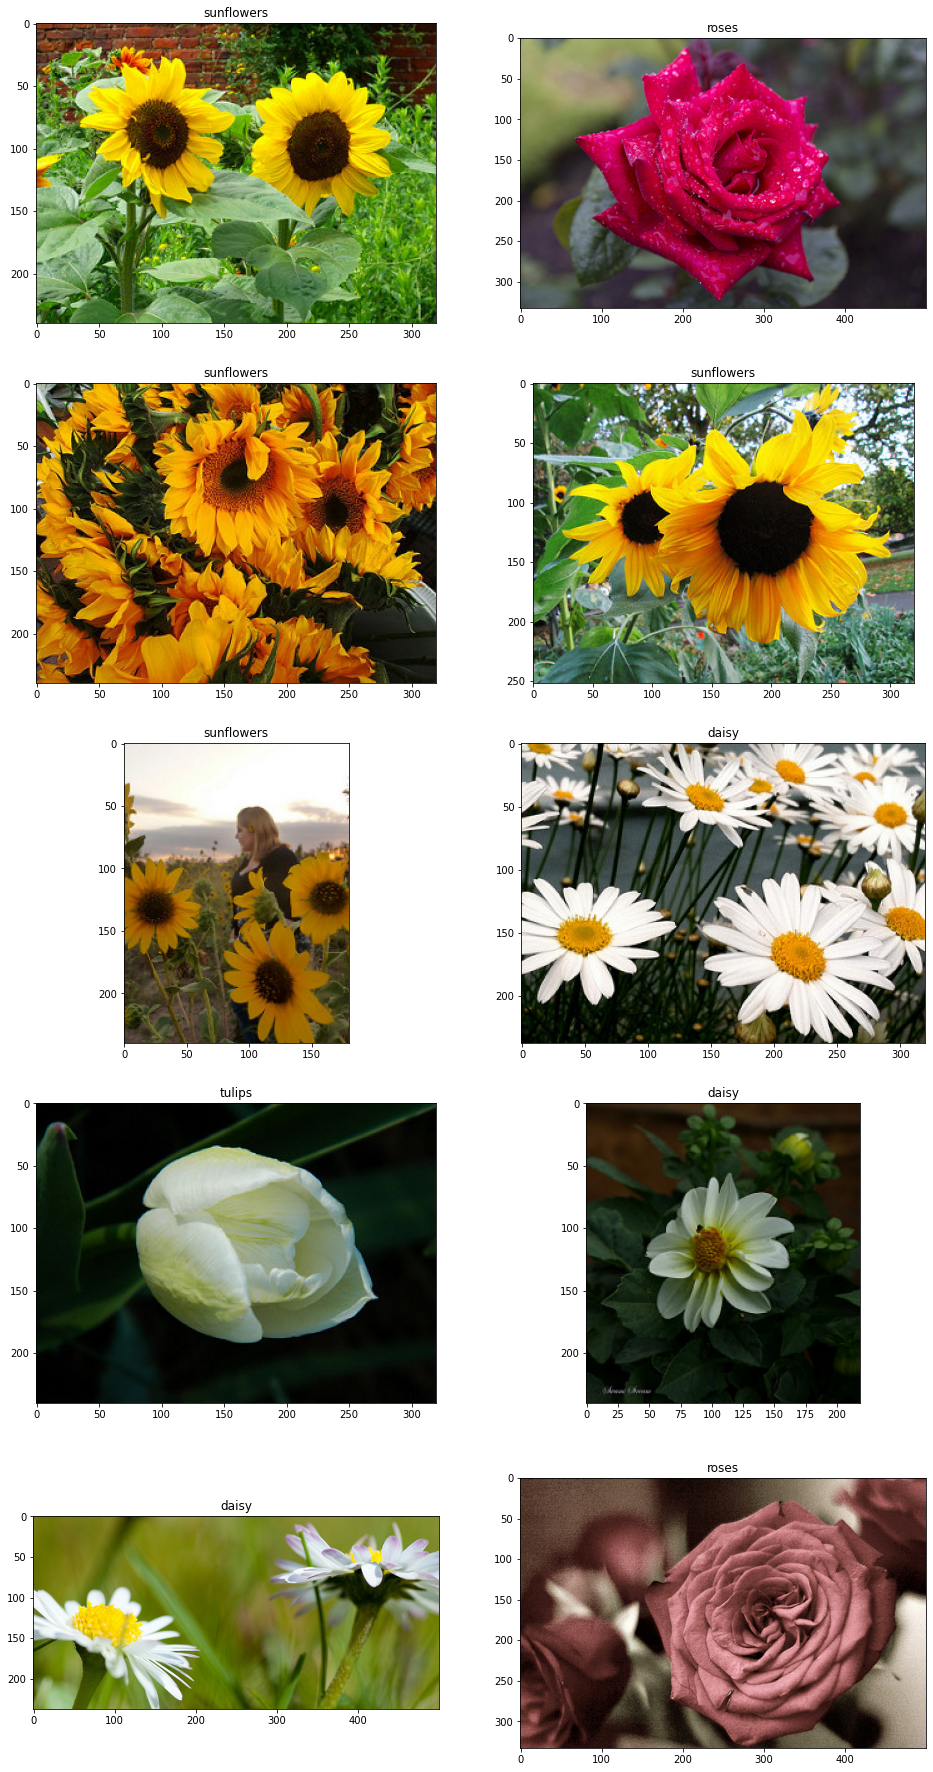

In [6]:
plt.rcParams["figure.figsize"] = (16, 32)

for i in range(10):
    rand_img = np.random.randint(0, len(data))
    plt.subplot(5, 2, i + 1)
    plt.imshow(data[rand_img][0][:,:,::-1])
    plt.title(classes[data[rand_img][1]])
plt.show()

### Image shapes

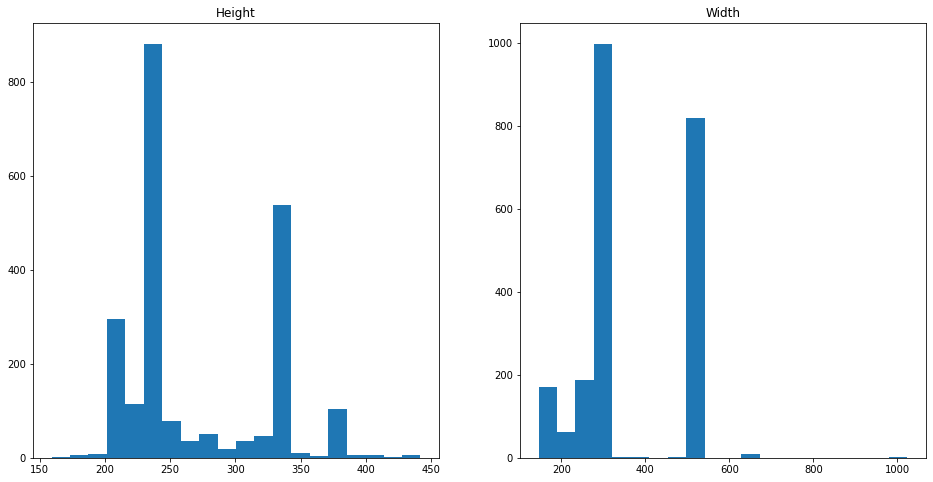

In [7]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.hist([x.shape[0] for x, _ in data], 20)
plt.title("Height")
plt.subplot(1, 2, 2)
plt.hist([x.shape[1] for x, _ in data], 20)
plt.title("Width")
plt.show()

### Data Split

In [8]:
random.shuffle(data)

train = data[:int(len(data) * 0.7)]
dev = data[int(len(data) * 0.7): int(len(data) * 0.85)]
test = data[int(len(data) * 0.85):]

print("Train:", len(train))
print("Dev:", len(dev))
print("Test:", len(test))

Train: 1575
Dev: 338
Test: 338


## FC Neural Network
### Preprocessing

In [9]:
vectorized_unsigned_gradient = np.vectorize(lambda x: x - 180 if x > 180 else x)

def extract_img_features(img, channel_hist_bins=64, hog_bins=9, p_size=8):
    # get hist of each channel
    b_hist, _ = np.histogram(img[:, :, 0], bins=channel_hist_bins)
    g_hist, _ = np.histogram(img[:, :, 1], bins=channel_hist_bins)
    r_hist, _ = np.histogram(img[:, :, 2], bins=channel_hist_bins)
    channel_hist = np.concatenate((b_hist, g_hist, r_hist), axis=0)
    channel_hist = channel_hist / channel_hist.max()

    # resize and cast for hog
    imgf = (tf.image.resize_with_crop_or_pad(img, 192, 192).numpy() / 255).astype(np.float32)

    # gx and gy
    gx = cv2.Sobel(imgf, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(imgf, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    # take max of mag along BGR channels
    max_mag_mask = np.argmax(mag, axis=2, keepdims=True)

    # apply the mask to both mag and angle matrix
    mag = np.take_along_axis(mag, max_mag_mask, axis=2).squeeze()
    angle = np.take_along_axis(angle, max_mag_mask, axis=2).squeeze()

    # "unsign" gradients
    vectorized_unsigned_gradient(angle)
    
    # init hog vector
    hog = np.zeros(shape=(imgf.shape[0] // p_size, imgf.shape[1] // p_size, hog_bins))
    for i in range(imgf.shape[0] // p_size):
        for j in range(imgf.shape[1] // p_size):
            # take a patch
            patch_angles = angle[i * p_size: (i + 1) * p_size, j * p_size: (j + 1) * p_size]
            patch_mag = mag[i * p_size: (i + 1) * p_size, j * p_size: (j + 1) * p_size]
            # calc hist
            hist, _ = np.histogram(patch_angles, bins=hog_bins, range=(0, 180), weights=patch_mag)
            # scale and save
            hog[i, j] = hist / (hist.max() + 1)
    hog = hog.flatten()
    return (np.concatenate((channel_hist, hog), axis=0)).astype(np.float32)

def nn_prepare_data(data, n_classes):
    x = np.array([extract_img_features(x, p_size=16) for x, y in data], dtype=np.float32)
    y = keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
    return x, y

In [10]:
train_x, train_y = nn_prepare_data(train, len(classes))
print("X:", train_x.shape, train_x.dtype)
print("Y:", train_y.shape, train_y.dtype)

X: (1575, 1488) float32
Y: (1575, 5) float32


In [11]:
dev_x, dev_y = nn_prepare_data(dev, len(classes))
print("X:", dev_x.shape, dev_x.dtype)
print("Y:", dev_y.shape, dev_y.dtype)

X: (338, 1488) float32
Y: (338, 5) float32


### Architecture

In [12]:
def build_nn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Dense(32)(X_in)
    X = layers.ReLU()(X)

    # dropout to reduce overfitting on some features
    X = layers.Dropout(0.2)(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [13]:
nn = build_nn((1488), len(classes))
print(nn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1488)]            0         
                                                                 
 dense (Dense)               (None, 32)                47648     
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 re_lu_1 (ReLU)              (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 85    

In [14]:
nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [15]:
nn_hist_train = nn.fit(x=train_x, y=train_y, validation_data=(dev_x, dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 1s 8ms/step - loss: 1.5368 - categorical_accuracy: 0.3003 - val_loss: 1.3844 - val_categorical_accuracy: 0.4349
Epoch 2/25
50/50 [==============================] - 0s 4ms/step - loss: 1.3999 - categorical_accuracy: 0.4089 - val_loss: 1.2835 - val_categorical_accuracy: 0.4497
Epoch 3/25
50/50 [==============================] - 0s 4ms/step - loss: 1.2971 - categorical_accuracy: 0.4521 - val_loss: 1.1811 - val_categorical_accuracy: 0.5030
Epoch 4/25
50/50 [==============================] - 0s 4ms/step - loss: 1.2273 - categorical_accuracy: 0.4895 - val_loss: 1.1438 - val_categorical_accuracy: 0.5237
Epoch 5/25
50/50 [==============================] - 0s 3ms/step - loss: 1.1717 - categorical_accuracy: 0.5448 - val_loss: 1.0993 - val_categorical_accuracy: 0.5621
Epoch 6/25
50/50 [==============================] - 0s 3ms/step - loss: 1.1008 - categorical_accuracy: 0.5511 - val_loss: 1.0851 - val_categorical_accuracy: 0.5621
Epoch 7/25
50/50

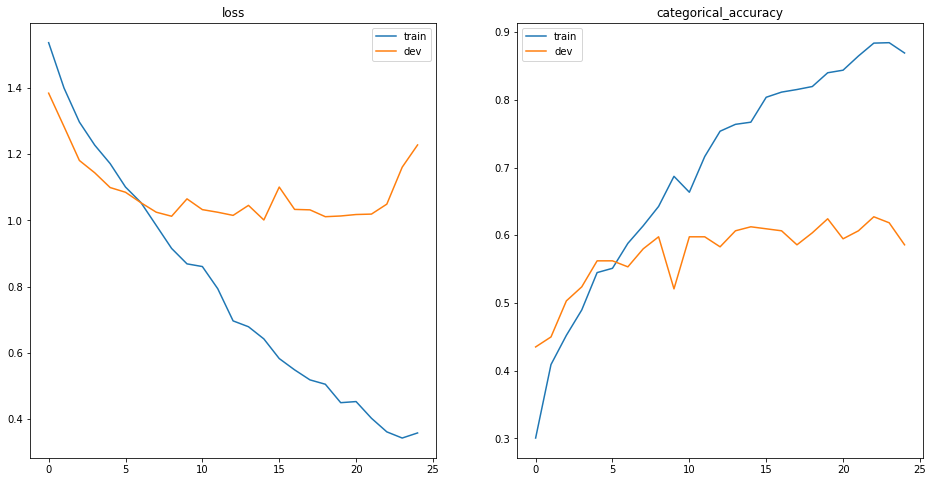

In [16]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(nn_hist_train.history["loss"], label="train")
plt.plot(nn_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(nn_hist_train.history["categorical_accuracy"], label="train")
plt.plot(nn_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

## Convolutional Neural Network
### Preprocessing

In [17]:
def cnn_prepare_data(data, h, w, n_classes):
    x = np.array([
        tf.image.resize_with_crop_or_pad((x / 255).astype(np.float32),
        target_height=h, target_width=w) for x, y in data], dtype=np.float32)

    y = keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
    return x, y

In [18]:
train_x, train_y = cnn_prepare_data(train, 192, 192, len(classes))
print("X:", train_x.shape, train_x.dtype)
print("Y:", train_y.shape, train_y.dtype)

X: (1575, 192, 192, 3) float32
Y: (1575, 5) float32


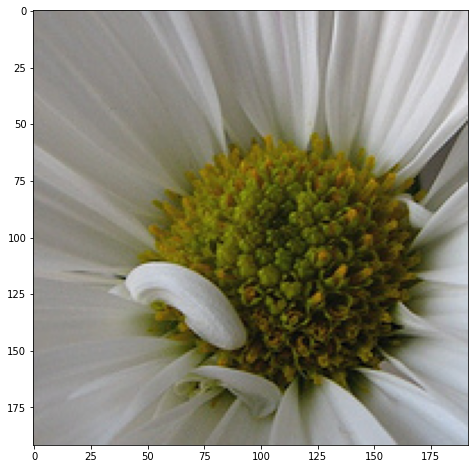

[1. 0. 0. 0. 0.]


In [19]:
example = 5
plt.imshow(train_x[example, :, :, ::-1])
plt.show()
print(train_y[example])

In [20]:
dev_x, dev_y = cnn_prepare_data(dev, 192, 192, len(classes))
print("X:", dev_x.shape, dev_x.dtype)
print("Y:", dev_y.shape, dev_y.dtype)

X: (338, 192, 192, 3) float32
Y: (338, 5) float32


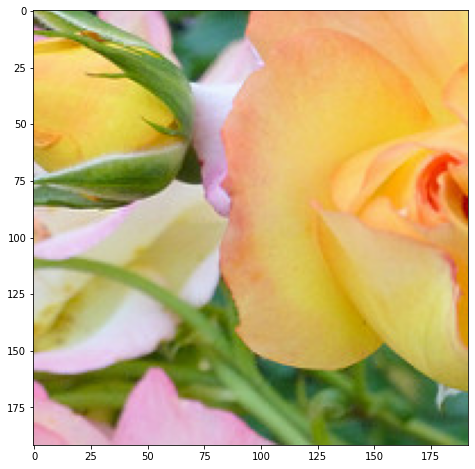

[0. 0. 1. 0. 0.]


In [21]:
example = 5
plt.imshow(dev_x[example, :, :, ::-1])
plt.show()
print(dev_y[example])

### CNN Architecture #1

In [22]:
def build_cnn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Conv2D(4, (3, 3), padding="same")(X_in)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(8, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(8, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(16, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(16, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(32, (3, 3), padding="same")(X)
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Flatten()(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [23]:
cnn = build_cnn((192, 192, 3), len(classes))
print(cnn.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 4)        0         
 )                                                               
                                                                 
 re_lu_2 (ReLU)              (None, 96, 96, 4)         0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 4)        16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 8)         296 

In [24]:
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [25]:
cnn_hist_train = cnn.fit(x=train_x, y=train_y, validation_data=(dev_x, dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 6s 54ms/step - loss: 1.7124 - categorical_accuracy: 0.2616 - val_loss: 1.5792 - val_categorical_accuracy: 0.3314
Epoch 2/25
50/50 [==============================] - 2s 36ms/step - loss: 1.4472 - categorical_accuracy: 0.3778 - val_loss: 1.6327 - val_categorical_accuracy: 0.3314
Epoch 3/25
50/50 [==============================] - 2s 36ms/step - loss: 1.2674 - categorical_accuracy: 0.4902 - val_loss: 1.7711 - val_categorical_accuracy: 0.2101
Epoch 4/25
50/50 [==============================] - 2s 38ms/step - loss: 1.1291 - categorical_accuracy: 0.5473 - val_loss: 1.7238 - val_categorical_accuracy: 0.2071
Epoch 5/25
50/50 [==============================] - 2s 40ms/step - loss: 1.0019 - categorical_accuracy: 0.6044 - val_loss: 1.8374 - val_categorical_accuracy: 0.3314
Epoch 6/25
50/50 [==============================] - 2s 35ms/step - loss: 0.8821 - categorical_accuracy: 0.6768 - val_loss: 2.0909 - val_categorical_accuracy: 0.3314
Epoch 7/25

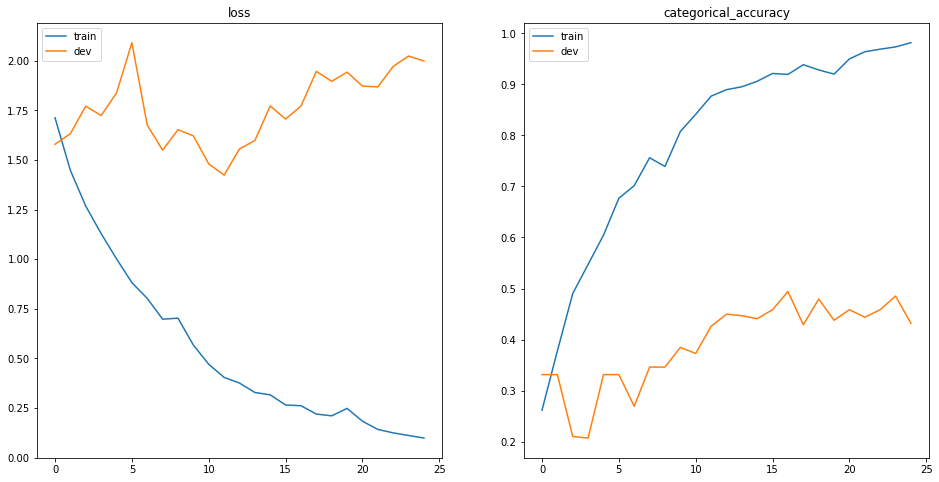

In [26]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn_hist_train.history["loss"], label="train")
plt.plot(cnn_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

### CNN Architecture #2: Inception-like (with Skip Connections)

In [27]:
def inception_block(input, f1, k1, f2, k2, f3, k3):
    X21 = layers.Conv2D(f1, k1, padding="same")(input)
    X22 = layers.Conv2D(f2, k2, padding="same")(X21)

    X31 = layers.Conv2D(f1, k1, padding="same")(input)
    X32 = layers.Conv2D(f3, k3, padding="same")(X31)

    # concatanate them, MaxPool, ReLU, BatchNorm
    X = layers.concatenate([X22, X32])
    X = layers.MaxPool2D()(X)
    X = layers.ReLU()(X)
    X = layers.BatchNormalization()(X)

    # skip-connection, with MaxPool'ed input so that the dimentions are matched with the rest
    P = layers.MaxPool2D()(input)
    X = layers.concatenate([X, P])
    return X


def build_inception_cnn(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = inception_block(
        X_in,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        2, (1, 1),
        2, (3, 3),
        2, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        8, (3, 3),
        8, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        8, (3, 3),
        8, (5, 5))
    
    X = layers.Flatten()(X)

    X = layers.Dense(16)(X)
    X = layers.ReLU()(X)

    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [28]:
cnn2 = build_inception_cnn((192, 192, 3), len(classes))
print(cnn2.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 192, 192, 2)  8           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 192, 192, 2)  8           ['input_3[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 192, 192, 2)  38          ['conv2d_6[0][0]']         

In [29]:
cnn2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [30]:
cnn2_hist_train = cnn2.fit(x=train_x, y=train_y, validation_data=(dev_x, dev_y), batch_size=32, epochs=25)

Epoch 1/25
50/50 [==============================] - 9s 123ms/step - loss: 1.7189 - categorical_accuracy: 0.3422 - val_loss: 1.4998 - val_categorical_accuracy: 0.3284
Epoch 2/25
50/50 [==============================] - 5s 93ms/step - loss: 1.2041 - categorical_accuracy: 0.5124 - val_loss: 1.5753 - val_categorical_accuracy: 0.3136
Epoch 3/25
50/50 [==============================] - 5s 90ms/step - loss: 1.0148 - categorical_accuracy: 0.5987 - val_loss: 1.5186 - val_categorical_accuracy: 0.2722
Epoch 4/25
50/50 [==============================] - 5s 92ms/step - loss: 0.8751 - categorical_accuracy: 0.6648 - val_loss: 1.4808 - val_categorical_accuracy: 0.3077
Epoch 5/25
50/50 [==============================] - 5s 91ms/step - loss: 0.7971 - categorical_accuracy: 0.7016 - val_loss: 1.5474 - val_categorical_accuracy: 0.3817
Epoch 6/25
50/50 [==============================] - 4s 88ms/step - loss: 0.7217 - categorical_accuracy: 0.7314 - val_loss: 1.4463 - val_categorical_accuracy: 0.3609
Epoch 7/2

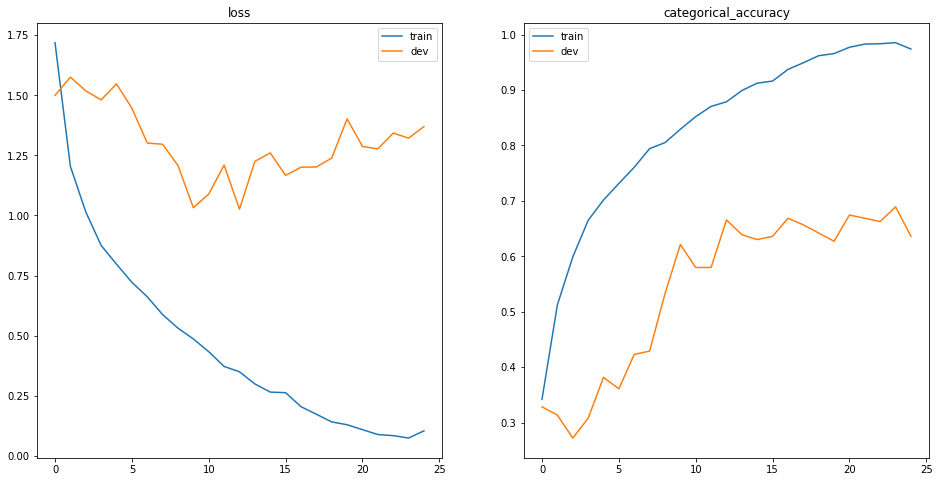

In [31]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn2_hist_train.history["loss"], label="train")
plt.plot(cnn2_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn2_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn2_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

Much better but overfitting is still significant

## Data Augmentation

In [32]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.3),
  layers.RandomContrast(0.1)
])

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

def cnn_prepare_data_a(data, h, w, n_classes, batch_size=32, shuffle=False, augment=False):
  
  ds = tf.data.Dataset.from_tensor_slices((
    np.array([
        tf.image.resize_with_crop_or_pad((x / 255).astype(np.float32),
        target_height=h, target_width=w) for x, y in data], dtype=np.float32),

        keras.utils.to_categorical([y for x, y in data], num_classes=n_classes, dtype=np.float32)
  ))

  if shuffle:
    ds = ds.shuffle(1000)

  # batch
  ds = ds.batch(batch_size)

  # train set augmentation
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [34]:
train_ds = cnn_prepare_data_a(train, 192, 192, len(classes), shuffle=True, augment=True)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [35]:
dev_ds = cnn_prepare_data_a(dev, 192, 192, len(classes))
dev_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### CNN on Augmented Data

In [36]:
cnn3 = build_inception_cnn((192, 192, 3), len(classes))
print(cnn3.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 192, 192, 2)  8           ['input_4[0][0]']                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 192, 192, 2)  8           ['input_4[0][0]']                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 192, 192, 2)  38          ['conv2d_30[0][0]']        

In [37]:
cnn3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [38]:
cnn3_hist_train = cnn3.fit(train_ds, validation_data=dev_ds, epochs=25)

Epoch 1/25
50/50 [==============================] - 10s 141ms/step - loss: 1.6495 - categorical_accuracy: 0.2940 - val_loss: 1.5663 - val_categorical_accuracy: 0.2101
Epoch 2/25
50/50 [==============================] - 8s 137ms/step - loss: 1.2460 - categorical_accuracy: 0.5010 - val_loss: 1.4969 - val_categorical_accuracy: 0.2870
Epoch 3/25
50/50 [==============================] - 7s 133ms/step - loss: 1.0475 - categorical_accuracy: 0.5841 - val_loss: 1.7609 - val_categorical_accuracy: 0.1982
Epoch 4/25
50/50 [==============================] - 8s 144ms/step - loss: 0.9562 - categorical_accuracy: 0.6184 - val_loss: 1.6352 - val_categorical_accuracy: 0.2988
Epoch 5/25
50/50 [==============================] - 8s 140ms/step - loss: 0.8846 - categorical_accuracy: 0.6483 - val_loss: 1.8086 - val_categorical_accuracy: 0.3254
Epoch 6/25
50/50 [==============================] - 8s 142ms/step - loss: 0.8786 - categorical_accuracy: 0.6641 - val_loss: 1.5264 - val_categorical_accuracy: 0.3728
Epo

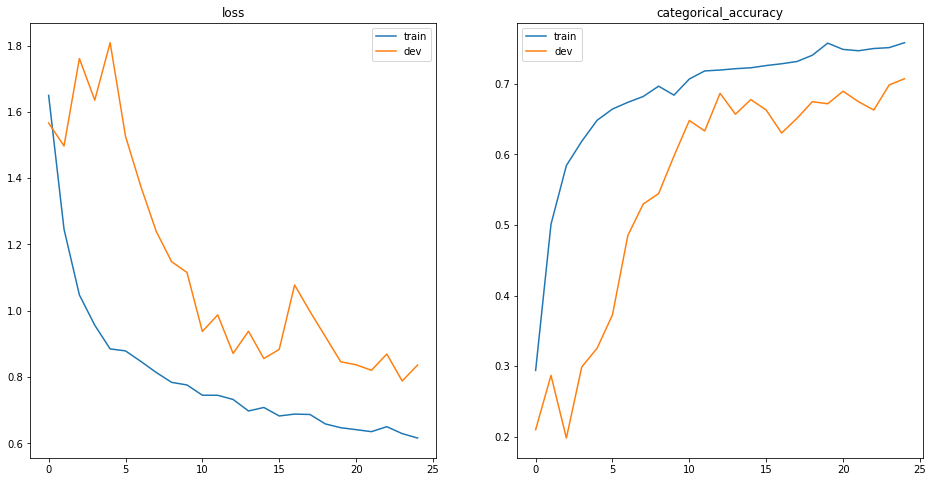

In [39]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn3_hist_train.history["loss"], label="train")
plt.plot(cnn3_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn3_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn3_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

### CNN Architecture #3: More complex

In [45]:
def build_inception_cnn_adv(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = inception_block(
        X_in,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        4, (3, 3),
        4, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        8, (3, 3),
        8, (5, 5))
    X = inception_block(
        X,
        4, (1, 1),
        8, (3, 3),
        8, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        16, (3, 3),
        16, (5, 5))
    X = inception_block(
        X,
        8, (1, 1),
        16, (3, 3),
        16, (5, 5))

    X = layers.Flatten()(X)
    X = layers.Dropout(0.2)(X)

    X = layers.Dense(32)(X)
    X = layers.ReLU()(X)
    X = layers.Dropout(0.2)(X)
    
    X = layers.Dense(n_classes)(X)
    X = layers.Softmax()(X)

    return keras.Model(inputs=X_in, outputs=X)

In [46]:
cnn4 = build_inception_cnn_adv((192, 192, 3), len(classes))
print(cnn4.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_78 (Conv2D)             (None, 192, 192, 4)  16          ['input_6[0][0]']                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 192, 192, 4)  16          ['input_6[0][0]']                
                                                                                                  
 conv2d_79 (Conv2D)             (None, 192, 192, 4)  148         ['conv2d_78[0][0]']        

In [47]:
cnn4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
    )

### Train

In [48]:
cnn4_hist_train = cnn4.fit(train_ds, validation_data=dev_ds, epochs=25)

Epoch 1/25
50/50 [==============================] - 12s 186ms/step - loss: 1.7192 - categorical_accuracy: 0.3206 - val_loss: 1.4367 - val_categorical_accuracy: 0.2308
Epoch 2/25
50/50 [==============================] - 10s 175ms/step - loss: 1.2470 - categorical_accuracy: 0.4381 - val_loss: 1.3441 - val_categorical_accuracy: 0.3876
Epoch 3/25
50/50 [==============================] - 9s 173ms/step - loss: 1.0892 - categorical_accuracy: 0.5498 - val_loss: 1.5256 - val_categorical_accuracy: 0.3609
Epoch 4/25
50/50 [==============================] - 9s 166ms/step - loss: 0.9677 - categorical_accuracy: 0.6114 - val_loss: 1.1138 - val_categorical_accuracy: 0.5059
Epoch 5/25
50/50 [==============================] - 9s 166ms/step - loss: 0.9691 - categorical_accuracy: 0.5994 - val_loss: 1.3009 - val_categorical_accuracy: 0.4527
Epoch 6/25
50/50 [==============================] - 9s 165ms/step - loss: 0.9542 - categorical_accuracy: 0.6095 - val_loss: 1.0398 - val_categorical_accuracy: 0.5947
Ep

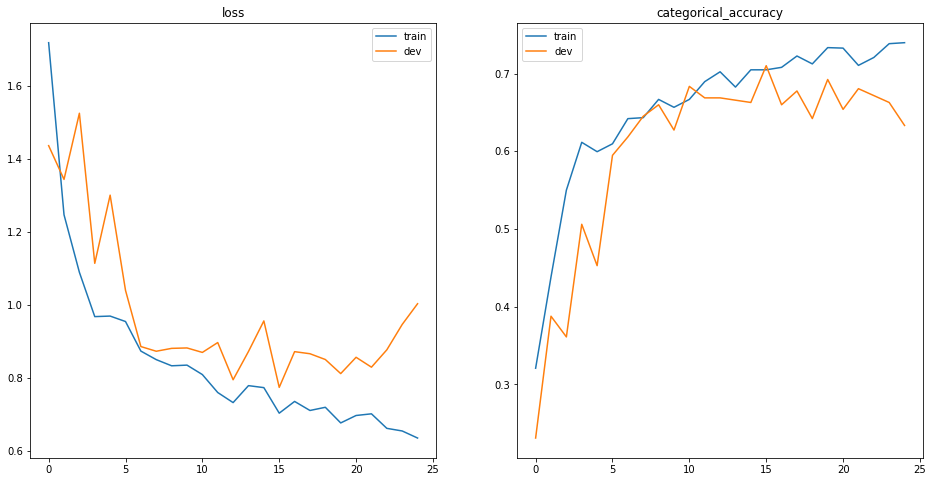

In [49]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(cnn4_hist_train.history["loss"], label="train")
plt.plot(cnn4_hist_train.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(cnn4_hist_train.history["categorical_accuracy"], label="train")
plt.plot(cnn4_hist_train.history["val_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()